In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from os import listdir, getcwd

from skimage.io import imread, imsave
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb, rgb2lab, lab2rgb
from skimage import img_as_ubyte

import warnings
warnings.filterwarnings('ignore')

# import utility functions
from merging_utilities.img_utils import *
from merging_utilities.os_utils import *
from merging_utilities.plotting import *
from merging_utilities.merging import *

# Read in Data

In [87]:
data_dir = get_img_dir()
data_dir

dirs = get_img_sets()
print('data directory: ', data_dir)
print('subdirectories: ', list(dirs.keys()))

data directory:  /Users/tbot/Dropbox/galvanize/blog_posts/merge_rgb_and_thermal_images/images/
subdirectories:  ['color', 'thermal']


In [88]:
image_set_filenames = get_img_sets()

color_img_filenames = image_set_filenames['color']
thermal_img_filenames = image_set_filenames['thermal']

parallel, not_parallel = verify_parallel_filenames(image_set_filenames)


YAY!, color and thermal directories are PARALLEL!


# Plot images

In [89]:
#get a sample image
img_num = 0

img1_rgb = imread(get_img_dir() + 'color/' + color_img_filenames[img_num])
img1_therm = imread(get_img_dir() + 'thermal/' + color_img_filenames[img_num])

# plot_images(img1_rgb, color_img_filenames[img_num] + ' rgb', img1_therm, color_img_filenames[img_num] + ' thermal')

# Plot Histograms

In [90]:
# plot_histograms(img1_rgb, color_img_filenames[img_num] + ' rgb', images=True)

In [91]:
# plot_histograms(img1_therm, color_img_filenames[img_num] + ' therm', images=True)

# Merging Images

## Average each layer with thermal layer

In [92]:
data_dir = get_img_dir()

samp_num = 0
img2_rgb = imread(data_dir + 'color/' + color_img_filenames[samp_num])
img2_therm = imread(data_dir + 'thermal/' + color_img_filenames[samp_num])

avg_img2 = avg_layers_with_thermal(img2_rgb, img2_therm)


# plot_images(img2_rgb, color_img_filenames[samp_num] + ' rgb', img2_therm, color_img_filenames[samp_num] + ' thermal')
# plot_image(avg_img2, color_img_filenames[samp_num] + ' rgb avgd with thermal')

## Convert RGB to LAB, replace L with Thermal, revert to RGB

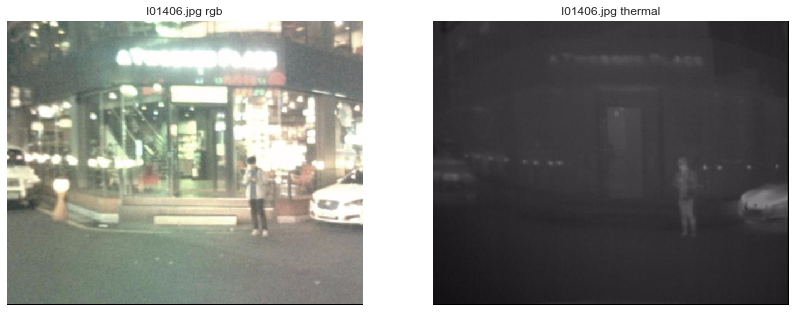

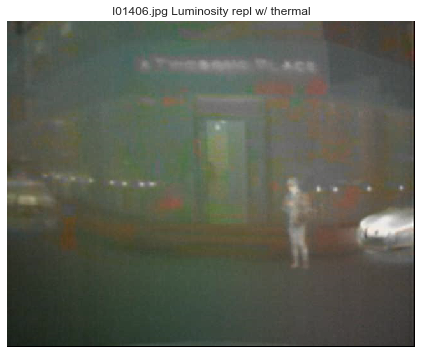

In [93]:
samp_num = 0
img3_rgb = imread(data_dir + 'color/' + color_img_filenames[samp_num])
img3_therm = imread(data_dir + 'thermal/' + color_img_filenames[samp_num])

img3_lum_w_therm = repl_light_with_therm(img3_rgb, img3_therm)


plot_images(img3_rgb, color_img_filenames[samp_num] + ' rgb', img3_therm, color_img_filenames[samp_num] + ' thermal')
plot_image(img3_lum_w_therm, color_img_filenames[samp_num] + ' Luminosity repl w/ thermal')